In [ ]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import itertools

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score,KFold, StratifiedKFold, TimeSeriesSplit,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix, f1_score
from sklearn.dummy import DummyRegressor, DummyClassifier

# For seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# to measure model performance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score ,mean_squared_error
# To model with sklearn
from sklearn.linear_model import Lasso, Ridge, LinearRegression, HuberRegressor, ElasticNet
from sklearn.utils.validation import check_is_fitted
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import ParameterGrid

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Loading Preprocessed Data**

In [ ]:
# Read the csv file into a pandas DataFrame and append to the list
train = pd.read_csv("/content/drive/My Drive/DataScience/train_data.csv")
test = pd.read_csv("/content/drive/My Drive/DataScience/test_data.csv")
validation =  pd.read_csv("/content/drive/My Drive/DataScience/validation_data.csv")

In [ ]:
train[train.columns[0]] = pd.to_datetime(train[train.columns[0]], dayfirst=False)
test[test.columns[0]] = pd.to_datetime(test[test.columns[0]], dayfirst=False)
validation[validation.columns[0]] = pd.to_datetime(validation[validation.columns[0]], dayfirst=False)

# Setting datetime as index
train.set_index(train.columns[0], inplace=True)
train.index.name =""
test.set_index(test.columns[0], inplace=True)
test.index.name =""
validation.set_index(validation.columns[0], inplace=True)
validation.index.name =""


## **Establishing Baseline**

In [ ]:
print('Start and end of training set:\t\t', train.index.min(), train.index.max())
print('Start and end of validation set:\t', validation.index.min(), validation.index.max())
print('Start and end of testing set:\t\t', test.index.min(), test.index.max())


Start and end of training set:		 2014-01-01 00:00:00 2021-12-31 23:00:00
Start and end of validation set:	 2022-01-01 00:00:00 2022-12-31 23:00:00
Start and end of testing set:		 2023-01-01 00:00:00 2024-01-05 09:00:00


## **Methods**

In [ ]:
def plot_timeseries(train,validation,test,x_label,y_label,y_feature,window_size=0, val_pred=None,test_pred=None):
  merged = pd.concat([train,validation,test], ignore_index=False)
  plt.figure(figsize=(16,8))
  plt.plot(merged.index, merged[y_feature])
  if val_pred is not None:
    plt.plot(validation.index[window_size:], val_pred, '--', color='orange', label='Forecast')
  if test_pred is not None:
    plt.plot(test.index[window_sizesize:], test_pred, '--', color='orange', label='Forecast')
  plt.axvspan(validation.index.min(), validation.index.max(), alpha=.2, color='red')
  plt.axvspan(test.index.min(), test.index.max(), alpha=.2, color='blue')
  plt.xlabel(x_label)
  plt.ylabel(y_label)

def recursive_forecasting(clf, data, horizon):
    forecast = []
    for step in range(horizon):
        p = clf.predict(data)
        pred = p[0]
        forecast.append(pred)
        data = np.roll(data, -1)
        data[0,-1] = pred
    return forecast

def measure_forecast_error(label, forecast):
    print("Evaluation Metrics")
    '''We will use this function to measure the performance of our baseline models'''
    print('MAE = %.2f' % mean_absolute_error(label, forecast))
    print('MAPE = %.2f%%' % (100*mean_absolute_percentage_error(label, forecast)))
    print('R2 = %.2f' % r2_score(label, forecast))

def create_windows(df, y_feature, forecast_horizon=1, window_size=24):
    # Add lagged values
    for lag in range(window_size):
        df[f'{y_feature}_{lag+1}'] = df[y_feature].shift(lag+1)

    # Define the target variable
    df['y'] = df[y_feature].shift(-forecast_horizon)

    # Drop rows with NaNs due to shifting
    df = df.dropna()

    return df

def forecast_24th_hour(model,X,window_size=24):
  # Forecasting next 24 hours
  predictions = recursive_forecasting(clf = model, data=X.reshape(1, -1),  horizon=24)
  predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
  return predictions[-1]

# Function to get original values from scaled
def reverse_transform(scaled_values, scaler):
    return scaler.inverse_transform(scaled_values.reshape(-1, 1)).flatten()


## **Plotting WindSpeed**

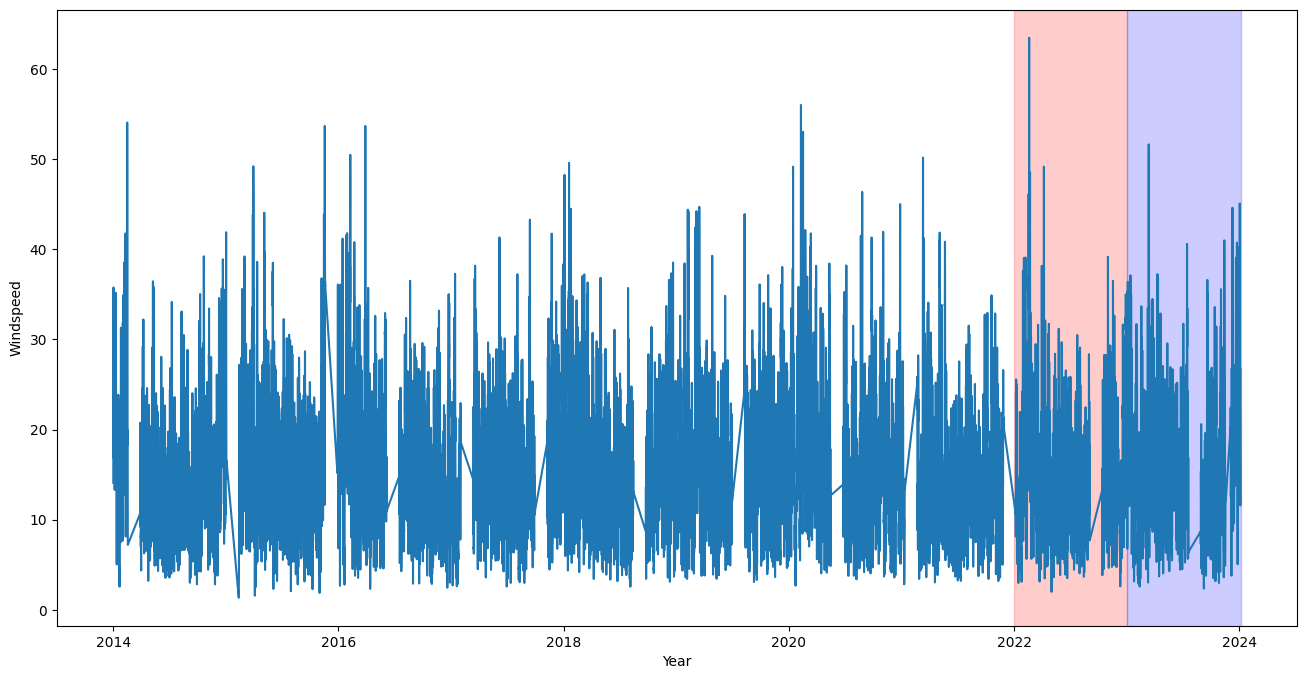

In [ ]:
plot_timeseries(train,validation,test,'Year','Windspeed','windspeed')

## **Baseline Model**

I'm using the last period as my baseline model, against which I'll be comparing my models.

Evaluation Metrics
MAE = 6.64
MAPE = 53.38%
R2 = -0.47


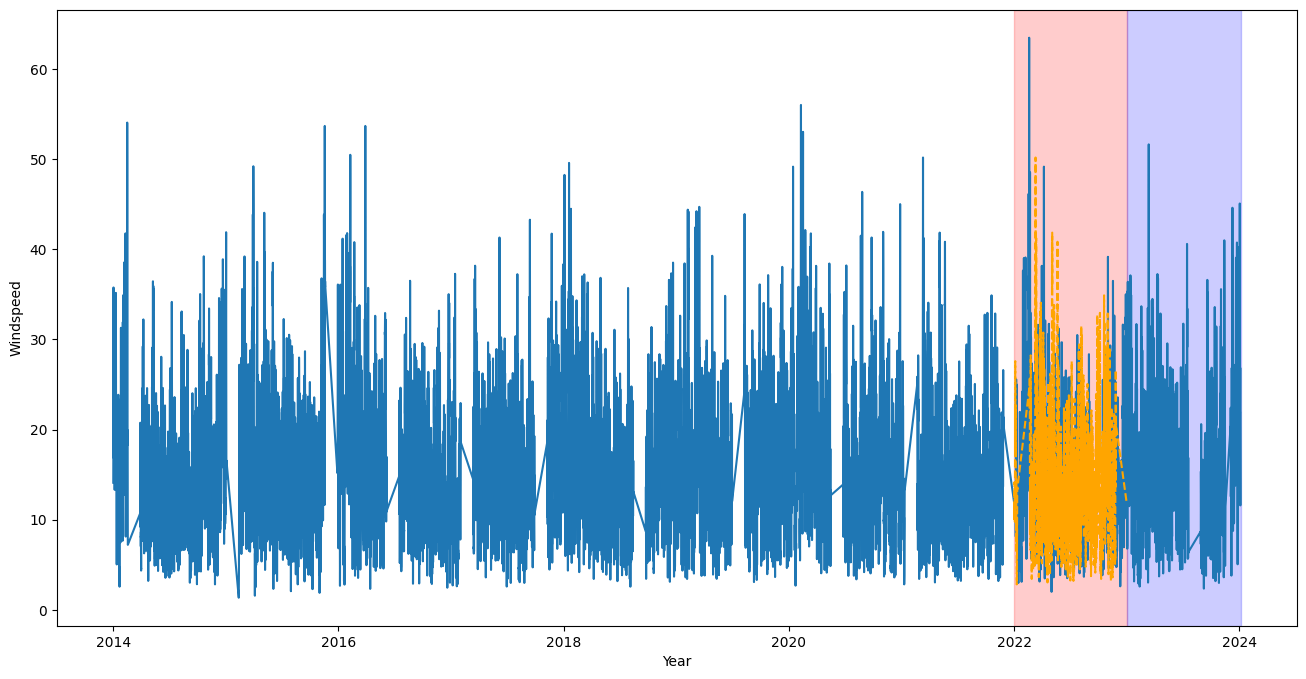

In [ ]:
validation['baseline_last_period'] = train.loc['2021']['windspeed'].values
measure_forecast_error(validation['windspeed'], validation['baseline_last_period'])

plot_timeseries(train,validation,test,'Year','Windspeed','windspeed',0,validation['baseline_last_period'])

## **Decision Tree Regressor**
I will be applying Decision Tree Regressor model to predict the 24 hours ahead

### **Normalizing the Data**

In [ ]:
train = train['windspeed'].copy().to_frame()

# Selecting only windspeed for forecasting
y_feature = 'windspeed'
# Scaling the data
scaler = MinMaxScaler()
train[y_feature], validation[y_feature], test[y_feature] = [scaler.fit_transform(df[[y_feature]]) for df in [train, validation, test]]

### **Creating Lagged Features**

Creating lagged features to capture temporal dependencies

In [ ]:
# Apply the method to each dataset
train = create_windows(train, y_feature)
validation = create_windows(validation, y_feature)
test = create_windows(test, y_feature)

### **Grid Search**
Appyling grid search to find optimal parameters

In [ ]:
# Implementing grid search
features = list(train.columns)[:-1]
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Initialize DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=42)

# Cross validation using time series split
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,cv=tscv,scoring='neg_mean_absolute_error',verbose=1)

# Fit GridSearchCV to training data
grid_search.fit(train[features], train['y'])

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (MAE):", best_score)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Score (MAE): 0.009807489581373695


### **Training model**
Now training model using the best parameters.

In [ ]:
features = list(train.columns)[:-1]
best_params = {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}
model = DecisionTreeRegressor(random_state=42,**best_params)
model.fit(train[features], train['y'])

DecisionTreeRegressor(max_depth=7, min_samples_split=10, random_state=42)

### **Evaluating model on Validation data**

In [ ]:
validation['y_pred_decision_tree'] = model.predict(validation[features])

# Reverse transform
val_pred = reverse_transform(validation['y_pred_decision_tree'].values, scaler)
val_actual = reverse_transform(validation['y'].values, scaler)

# Calculating evaluation metrics
print("==================================")
print("Decision Tree Regressor")
measure_forecast_error(val_actual, val_pred)
print("==================================")

Decision Tree Classifier
Evaluation Metrics
MAE = 0.43
MAPE = 3.74%
R2 = 0.99


**Plotting validation predictions**

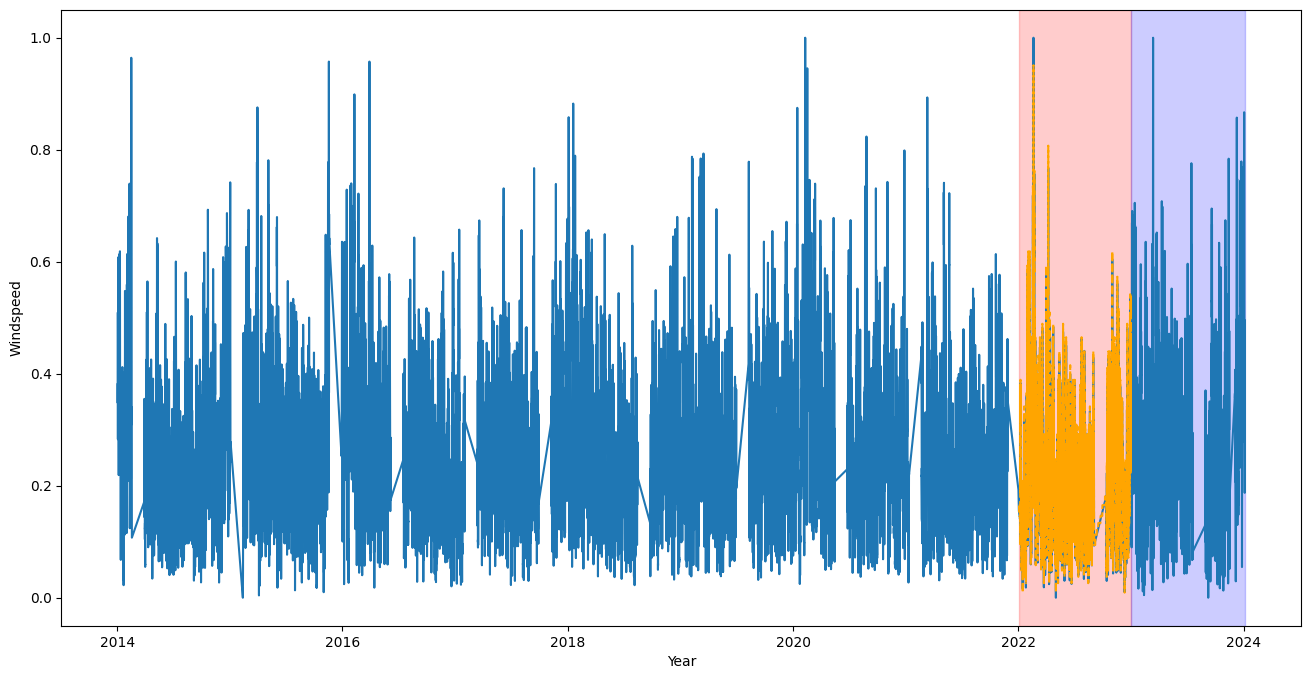

In [ ]:
plot_timeseries(train,validation,test,'Year','Windspeed','y',0,val_pred=validation['y_pred_decision_tree'],test_pred=None)

### **Evaluating model on Test data**

In [ ]:
test['y_pred_decision_tree'] = model.predict(test[features])

# Reverse transform
test_pred = reverse_transform(test['y_pred_decision_tree'].values, scaler)
test_actual = reverse_transform(test['y'].values, scaler)

# Calculating evaluation metrics
print("==================================")
print("Decision Tree Regressor")
measure_forecast_error(test_actual,test_pred)
print("==================================")

Decision Tree Classifier
Evaluation Metrics
MAE = 0.54
MAPE = 4.03%
R2 = 0.99


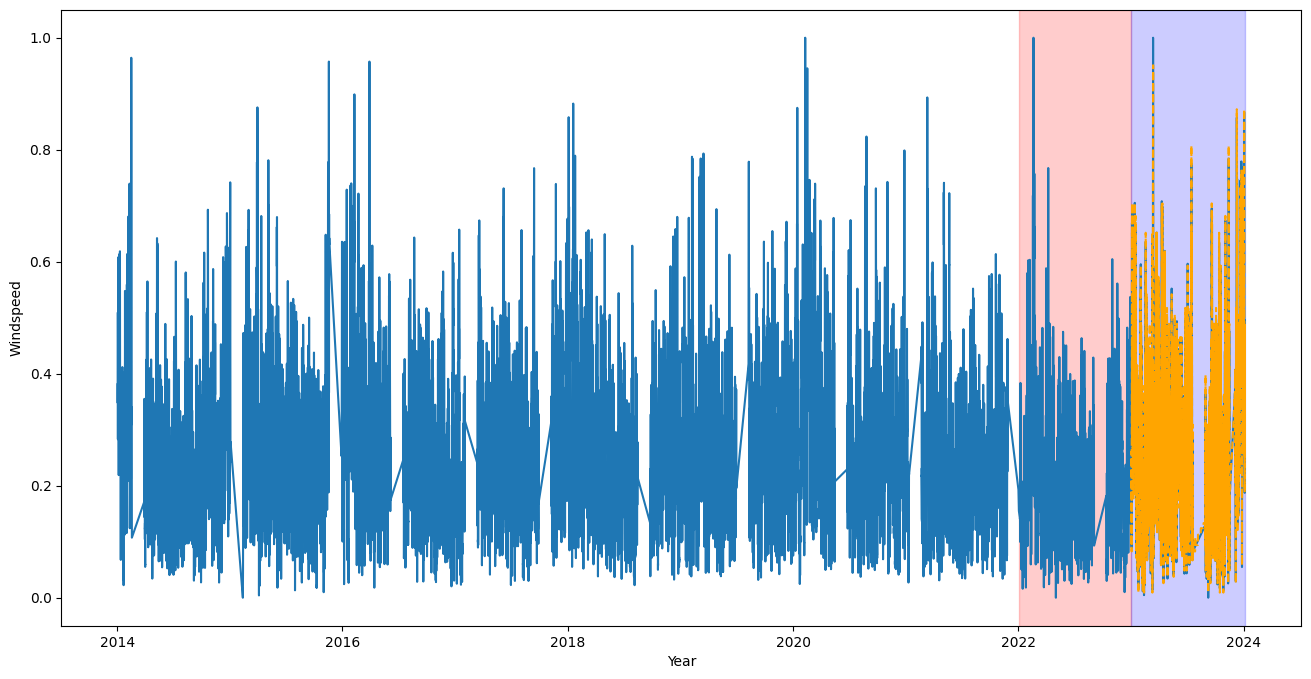

In [ ]:
# Plotting test predictions
plot_timeseries(train,validation,test,'Year','Windspeed','y',0,val_pred=None,test_pred=test['y_pred_decision_tree'])

In this model, we are forecasting the next hour using the previous 24 hours. We will use this model recursively to forecast the next 24 hours by also appending the newly predicted data iteratively. In this way, we forecast the 24th hour in the future.

### **Energy Generation formulas**
We will be considering only wind power as UK is known for the one of the best location for wind power in the world.

Ref:https://en.wikipedia.org/wiki/Wind_power_in_the_United_Kingdom


#### Wind Energy

We are assuming we have 500 household that can take advantage of surplus energy.

Considering
- 200 household of flat or 1 bedroom = 1800 kWH per year per household
- 150 household of 2-3 bedrooms = 2700 kWH per year per household
- 150 household of 4-5 bedrooms = 4100 kWH per year per household

Average electricity consumption of household

- Average KW consumed per hour = ((200 * 1800) + (150 * 2700) + (150 * 4100))/8760 = 157.53 KW (Total consumption)

Ref: https://www.geeksforgeeks.org/wind-energy-formula/

Ref: https://www.ofgem.gov.uk/information-consumers/energy-advice-households/average-gas-and-electricity-use-explained



In [ ]:
#Constants based on assumptions
total_consumption_per_hour = 158 # KW
blade_length = 57.5 # m
wind_energy_threshold = total_consumption_per_hour * 4  # KW
density = 1.23 #kg/m
no_of_turbines = 50
def calculate_wind_electricity(wind_speed):
    swept_area = blade_length * 3.14
    # Converting speed into m/s
    wind_speed = wind_speed / 3.6
    # Calculating wind energy
    power = 0.5 * density * swept_area * (wind_speed)**3
    power = no_of_turbines * power
    return round(power / 1000, 2) # KW


## **Forcasting 24 hours ahead using Recursive Forecasting**

In [ ]:
wind_energy = []
windspeed_predictions = []
for i in range(len(test)-24):
  # Forecast the 24th hour using past 24 hours observations
  windspeed = forecast_24th_hour(model,test[features].values[i,:],24)
  windspeed_predictions.append(windspeed)
  wind_energy.append(calculate_wind_electricity(windspeed))

**Plotting predictions**

We are plotting predictions with threshold line to check for any false positives.


Text(0, 0.5, 'Wind Energy Generation')

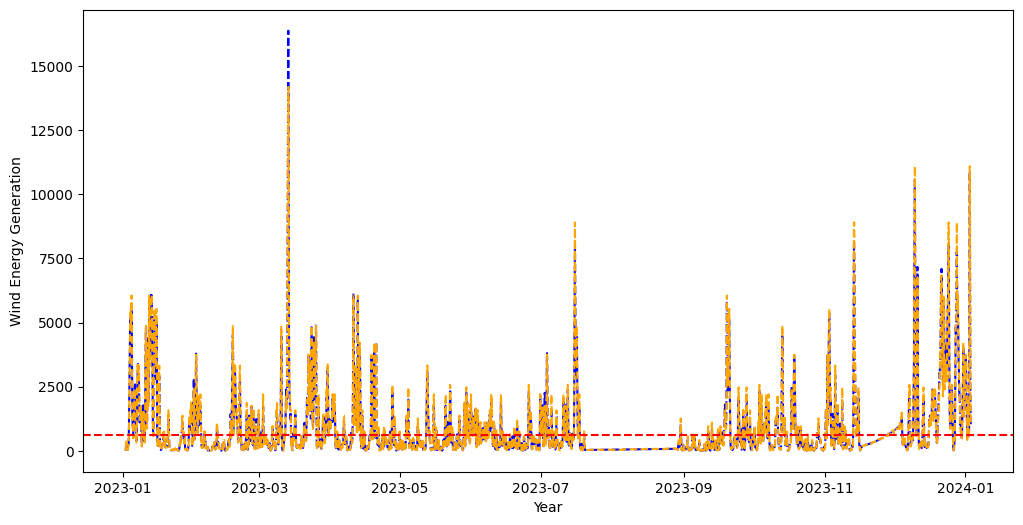

In [ ]:
actual_y= reverse_transform(test['y'].values,scaler)
actual_wind_energy = [calculate_wind_electricity(ws) for ws in actual_y]
window_size = 24
adjust = 48
plt.figure(figsize=(12,6))
plt.plot(test.index[:-adjust], actual_wind_energy[:-adjust], '--', color='blue', label='True Values')
plt.plot(test.index[:-adjust], wind_energy[window_size:], '--', color='orange', label='Forecast')
plt.axhline(y=wind_energy_threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel("Year")
plt.ylabel("Wind Energy Generation")

As we can see that there aren't any false positives in our predictions.

**Plotting subset of predictions**

Now plotting May 2023 predictions to assess the performance of our model, helping us decide whether to deploy it in May 2024 or not.

Text(0, 0.5, 'Wind Energy Generation')

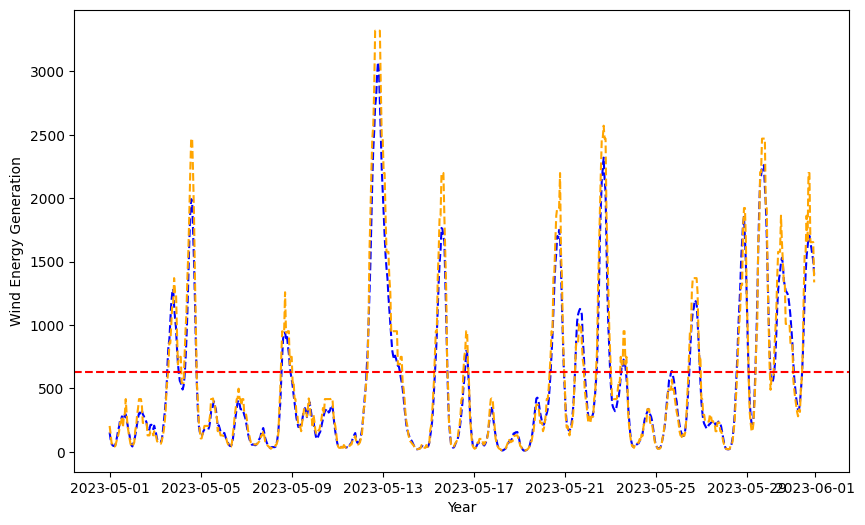

In [ ]:
may_data = test.loc['2023-05']
may_pred = wind_energy[window_size:]
may_pred = may_pred[2856:len(may_data)+2856]
may_actual = [calculate_wind_electricity(ws) for ws in actual_y[2856:len(may_data)+2856]]
plt.figure(figsize=(10,6))
plt.plot(may_data.index, may_actual, '--', color='blue', label='True Values')
plt.plot(may_data.index, may_pred, '--', color='orange', label='Forecast')
plt.axhline(y=wind_energy_threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel("Year")
plt.ylabel("Wind Energy Generation")

No false positives for May 2023.

We can see that our model is forecasting quite good.

## **Calculating monthly R2 values**
Let's check in which months our model performs well.

In [ ]:
test['y'] = actual_y
windspeed_actual = test[:-adjust]['y']
windspeed_predictions = windspeed_predictions[window_size:]
monthly_R2 = []
start = 0
end=0
for i in range(12):
  monthly_true = windspeed_actual.loc['2023-'+str(i+1)]
  end = end+ len(monthly_true)
  monthly_pred = windspeed_predictions[start:end]
  start = end
  monthly_R2.append(r2_score(monthly_true, monthly_pred))

print("R2 Values:")
print(monthly_R2)


R2 Values:
[0.9898610557995389, 0.9848154115645426, 0.9850223374521143, 0.9843905545480034, 0.9754912977131404, 0.9719161118042271, 0.9896497037848242, 0.9354490275802705, 0.9849853498126055, 0.981245066783269, 0.9859771873692132, 0.9861065364869159]


### **Plotting monthly R2**

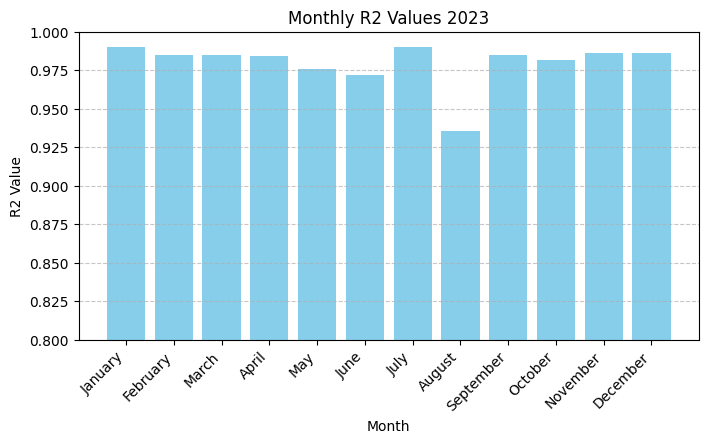

In [ ]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# Plotting the bar chart
plt.figure(figsize=(8, 4))
plt.bar(months, np.array(monthly_R2), color='skyblue')
plt.xlabel('Month')
plt.ylabel('R2 Value')
plt.title('Monthly R2 Values 2023')
plt.ylim(0.8, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.show()

We can observe that our model performs well in every month, including May 2023. Therefore, there is a high possibility that our model will perform well in May 2024 as well. This suggests that our model can be deployed in May 2024.